# Low-rank nonnegative tensor approximation via alternating projections and sketching

In [1]:
import sys
sys.path.append('./src')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as spio
from time import time

from truncatedSvd import TruncatedSvd
from experiment import Experiment

In [2]:
%%bash
lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   39 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          4
On-line CPU(s) list:             0-3
Vendor ID:                       GenuineIntel
Model name:                      Intel(R) Core(TM) i3-8130U CPU @ 2.20GHz
CPU family:                      6
Model:                           142
Thread(s) per core:              2
Core(s) per socket:              2
Socket(s):                       1
Stepping:                        10
BogoMIPS:                        4415.99
Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology cpuid pni pclmulqdq vmx ssse3 fma cx16 pcid sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single 

# 1. Multidimensional Gaussian mixture

## 1. 1. 3D

In [109]:
t0 = time()

N = 128
N1 = N
N2 = N
N3 = N
A = np.zeros([N1, N2,N3])
cov_mat = np.random.uniform(0, 1, [3,3])
cov_mat = cov_mat @ cov_mat.T
cov_mat = cov_mat / np.linalg.norm(cov_mat)
cov_mat2 = np.random.uniform(0, 1, [3,3])
cov_mat2 = cov_mat2 @ cov_mat2.T
cov_mat2 = cov_mat2 / np.linalg.norm(cov_mat2)

cov_mat3 = np.random.uniform(0, 1, [3,3])
cov_mat3 = cov_mat3 @ cov_mat3.T
cov_mat3 = cov_mat3 / np.linalg.norm(cov_mat3)

h = 4. / N
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            point = np.array([i*h, j*h, k*h])
            A[i,j,k] = np.exp(-point @ cov_mat  @ point) +\
                       np.exp(-point @ cov_mat2 @ point) +\
                       np.exp(-point @ cov_mat3 @ point)
            
print('%d s.' % (time() - t0))

59 s.


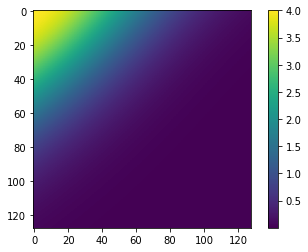

In [148]:
plt.imshow(A[:, :, 0, 0])
_ = plt.colorbar()

In [124]:
nsthosvdTruncatedSvdList = []
nsthosvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=1,  k=15))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=0,  k=16))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=10, l=25))
# nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=6,  l=11))

nttsvdTruncatedSvdList = []
nttsvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=1, k=14))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=0, k=14))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=7, l=29))
# nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=6, l=10))

nlrtTruncatedSvdList = []
nlrtTruncatedSvdList.append(TruncatedSvd('SVDr'))


tuckerRank = (5, 5, 5)
ttRank = (5, 5)
itersNum = 100

ex = Experiment(tensor=A,
                tuckerRank=tuckerRank,
                ttRank=ttRank,
                nsthosvdTruncatedSvdList=nsthosvdTruncatedSvdList,
                nttsvdTruncatedSvdList=nttsvdTruncatedSvdList,
                nlrtTruncatedSvdList=nlrtTruncatedSvdList)

In [125]:
ex.runInitialSvd()

TTSVD
-------------------------------------------
time (s.)                    |      0.35392
negative elements (fro)      |     0.004421
negative elements (che)      |     0.000036
negative elements (%)        |  12.56022453
relative error (fro)         | 0.0001236570
relative error (che)         | 0.0005587942
SNR (dB)                     | 39.077814258
r2_score                     | 0.9999999837
compression                  |       468.11
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      0.38357
negative elements (fro)      |     0.004740
negative elements (che)      |     0.000043
negative elements (%)        |   6.27274513
relative error (fro)         | 0.0001334205
relative error (che)         | 0.0005792421
SNR (dB)                     | 38.747772814
r2_score                     | 0.9999999810
compression                  |      1025.50
-------------------------------------------


In [58]:
ex.time(itersNum, nttsvd=True, nsthosvd=False, nlrt=False)

NTTSVD
------------------------------------
SVD$_r$                 |  45.93 s.
HMT(1,14), Rad          |  11.42 s.
HMT(0,14), Rad          |   8.09 s.
Tropp(7,29), Rad        |   6.36 s.
------------------------------------


In [59]:
ex.time(itersNum, nttsvd=False, nsthosvd=True, nlrt=False)

NSTHOSVD
------------------------------------
SVD$_r$                 |  45.62 s.
HMT(1,15), Rad          |  12.18 s.
HMT(0,16), Rad          |   8.53 s.
Tropp(10,25), Rad       |   7.54 s.
------------------------------------


In [181]:
ex.time(itersNum, nttsvd=False, nsthosvd=False, nlrt=True)

NLRT
------------------------------------
SVD$_r$                 | 113.34 s.
------------------------------------


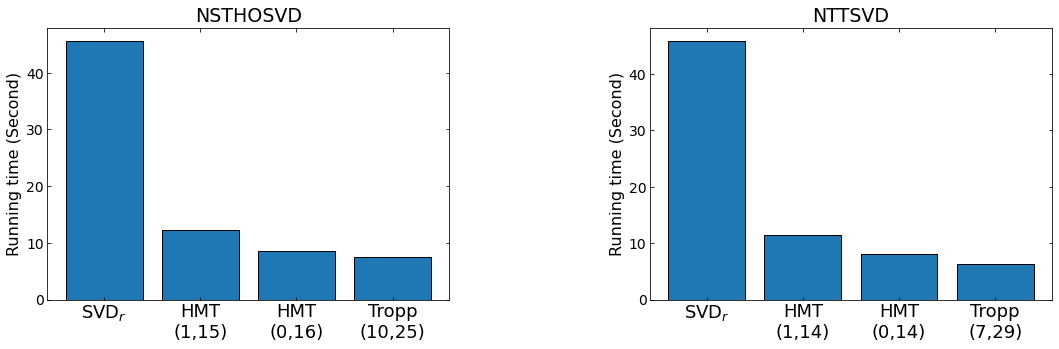

In [60]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=19,
                          ylabelsize=16,
                          xticksize=18,
                          yticksize=14,
                          wspace=0.5,
                          paramsNewLine=True)

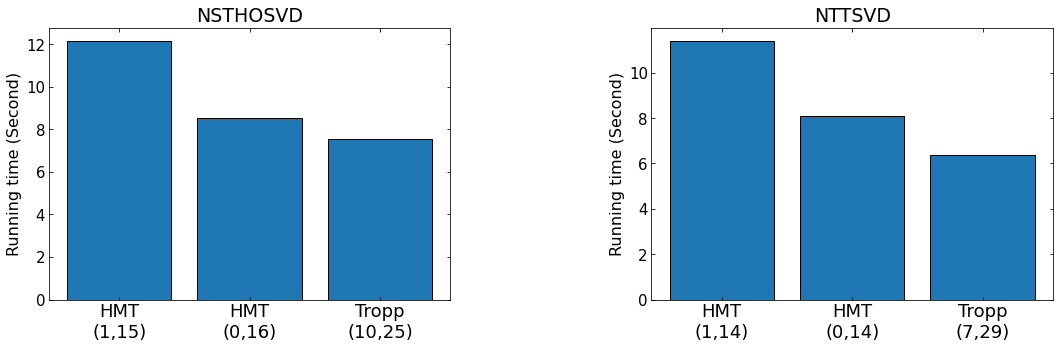

In [61]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=19,
                          ylabelsize=16,
                          xticksize=18,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True,
                          exclude=[0])

In [126]:
ex.run(itersNum)

NTTSVD
------------------------------------
SVD$_r$                  |  55.95 s.
HMT(1,14), Rad           |  11.24 s.
HMT(0,14), Rad           |   8.79 s.
Tropp(7,29), Rad         |   7.68 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  |  53.34 s.
HMT(1,15), Rad           |  10.87 s.
HMT(0,16), Rad           |   9.41 s.
Tropp(10,25), Rad        |   8.46 s.
------------------------------------
NLRT
------------------------------------
SVD$_r$                  | 203.62 s.
------------------------------------


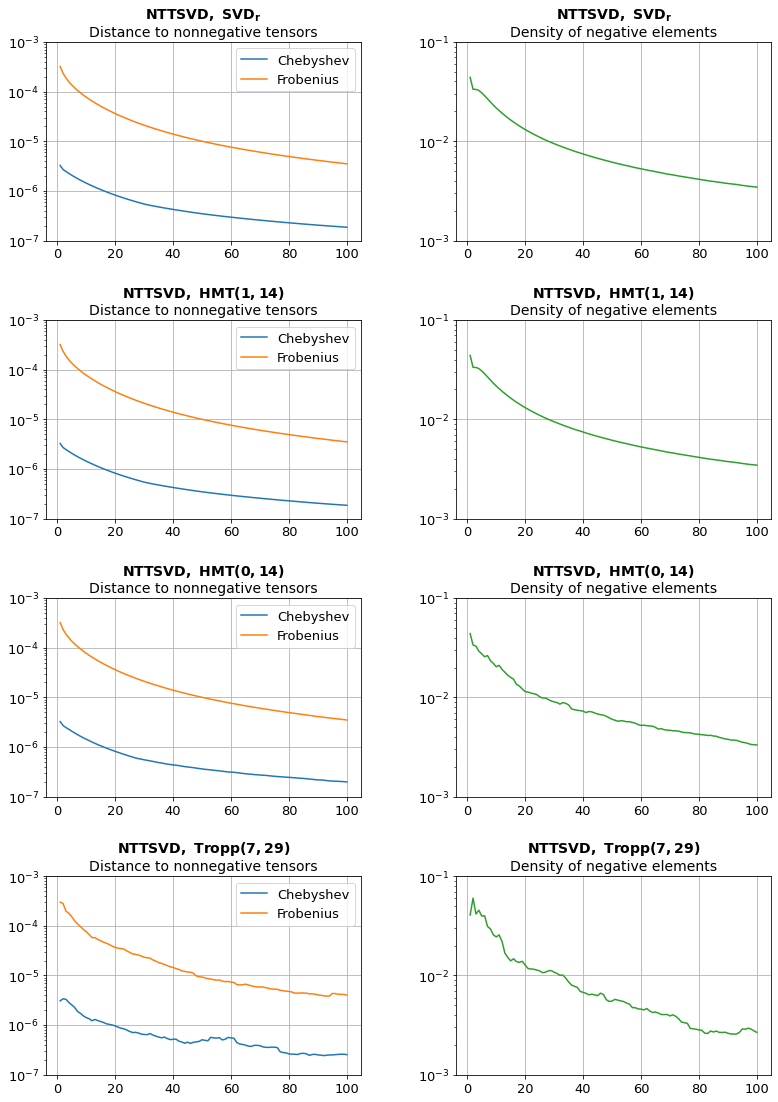

In [80]:
fig, ax = ex.plotConvergence2(nsthosvd=False,
                              figsize=(13, 19),
                              yticks=[10**(-x) for x in range(3, 8)],
                              yticks2=[10**(-x) for x in range(1, 4)],
                              hspace=0.4, wspace=0.3,
                              titlesize=14,
                              ticksize=13,
                              legendsize=13,
                              legendloc='upper right')z

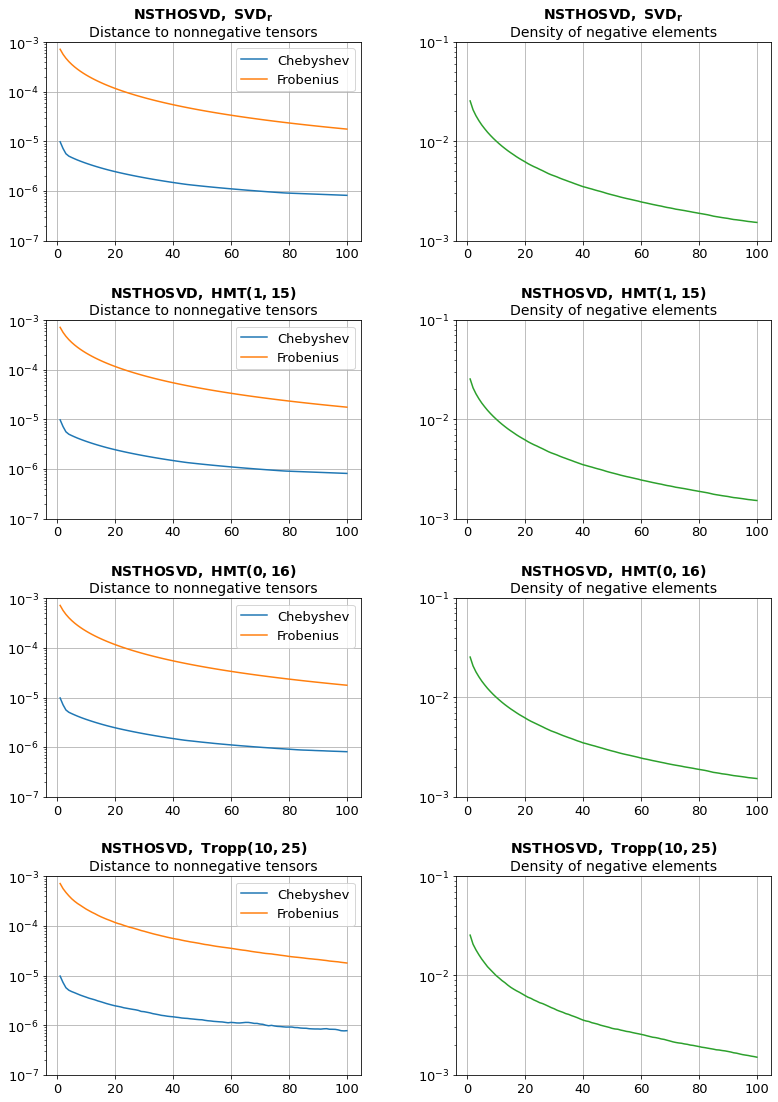

In [81]:
fig, ax = ex.plotConvergence2(nttsvd=False,
                              figsize=(13, 19),
                              yticks=[10**(-x) for x in range(3, 8)],
                              yticks2=[10**(-x) for x in range(1, 4)],
                              hspace=0.4, wspace=0.3,
                              titlesize=14,
                              ticksize=13,
                              legendsize=13,
                              legendloc='upper right')

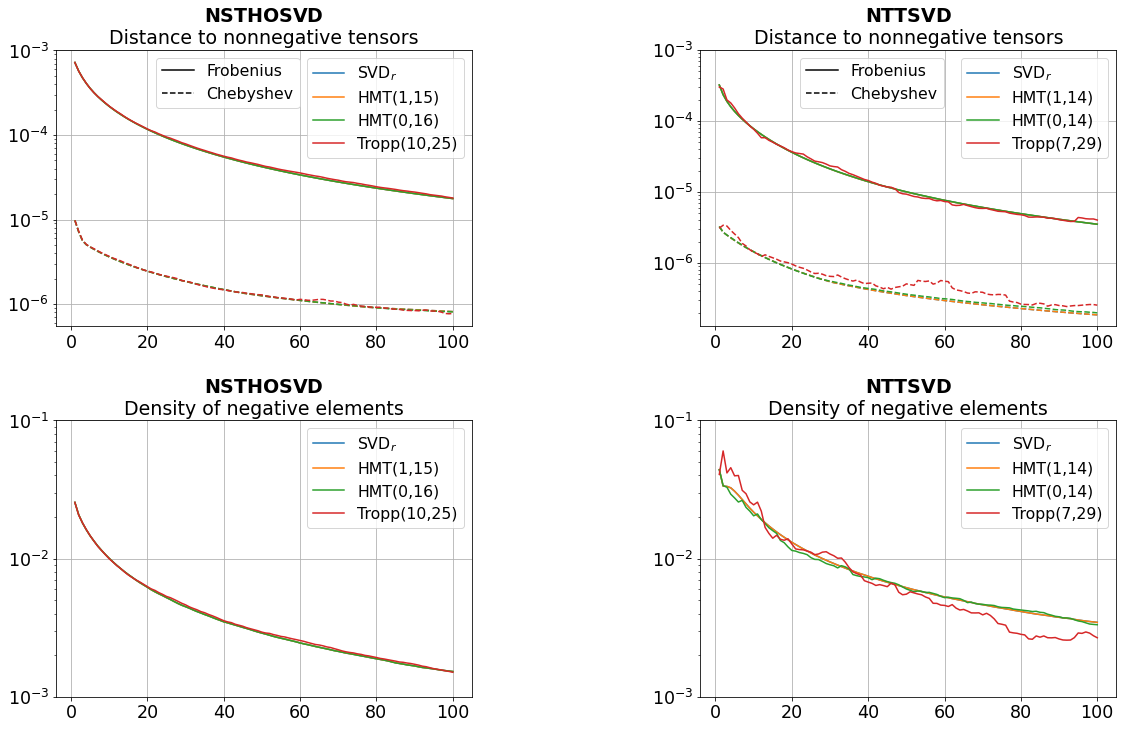

In [71]:
fig, ax = ex.plotConvergence3(figsize=(19, 11.9),
                              yticks=[10**(-x) for x in range(3, 7)],
                              yticks2=[10**(-x) for x in range(1, 4)],
                              wspace=0.55,
                              hspace=0.34,
                              titlesize=19,
                              ticksize=17.5,
                              legendsize=15.74,
                              legendloc='upper right',
                              legend2loc=(0.24, 0.79))

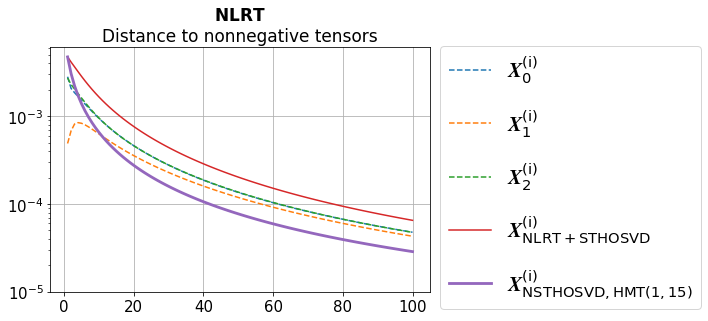

In [127]:
fig, ax = ex.plotConvergence(nttsvd=False,
                             nsthosvd=False,
                             nlrt=True,
                             figsize=(6.8, 4.5),
                             titlesize=17,
                             ticksize=15,
                             legendsize=21,
                             bbox_to_anchor=(1, 1.0485),
                             labelspacing=1.06,
                             yticks=[10**(-x) for x in range(3, 6)])

In [128]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000125896684650040 | 0.000572621516940301 | 38.99986 | 1.000000 |
| HMT(1,14), Rad           | 0.000125896684649550 | 0.000572621516690723 | 38.99986 | 1.000000 |
| HMT(0,14), Rad           | 0.000125904877987045 | 0.000571838278173124 | 38.99957 | 1.000000 |
| Tropp(7,29), Rad         | 0.000127631439670505 | 0.000628154819077853 | 38.94042 | 1.000000 |
------------------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000136232356129629 | 0.000593693771091530 | 38.65720 | 1.000000 |
| HMT(1,15), Rad           | 0

In [129]:
ex.printNegativePart()

| NTTSVD                   | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000016187350752277211 | 0.000002809879454782700 | 0.309085845947265625000 |
| HMT(1,14)                | 0.000016187350776507548 | 0.000002809879463432099 | 0.309085845947265625000 |
| HMT(0,14)                | 0.000016513708881839936 | 0.000002735039089338798 | 0.323057174682617187500 |
| Tropp(7,29)              | 0.000019107033751470198 | 0.000001897978147283858 | 0.225973129272460937500 |
----------------------------------------------------------------------------------------------------------
| NSTHOSVD                 | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000028

## 1.2. 4D

In [33]:
t0 = time()

N = 64
N1 = N
N2 = N
N3 = N
N4 = N
A = np.zeros([N1, N2,N3, N4])

cov_mat = np.random.uniform(0, 1, [4,4])
cov_mat = cov_mat @ cov_mat.T
cov_mat = cov_mat / np.linalg.norm(cov_mat)

cov_mat2 = np.random.uniform(0, 1, [4,4])
cov_mat2 = cov_mat2 @ cov_mat2.T
cov_mat2 = cov_mat2 / np.linalg.norm(cov_mat2)

cov_mat3 = np.random.uniform(0, 1, [4,4])
cov_mat3 = cov_mat3 @ cov_mat3.T
cov_mat3 = cov_mat3 / np.linalg.norm(cov_mat3)

cov_mat4 = np.random.uniform(0, 1, [4,4])
cov_mat4 = cov_mat4 @ cov_mat4.T
cov_mat4 = cov_mat4 / np.linalg.norm(cov_mat4)

h = 4. / N
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            for l in range(N4):
                point = np.array([i*h, j*h, k*h, l*h])
                A[i,j,k,l] = np.exp(-point @ cov_mat  @ point) +\
                             np.exp(-point @ cov_mat2 @ point) +\
                             np.exp(-point @ cov_mat3 @ point) +\
                             np.exp(-point @ cov_mat4 @ point)
            
print('%d s.' % (time() - t0))

567 s.


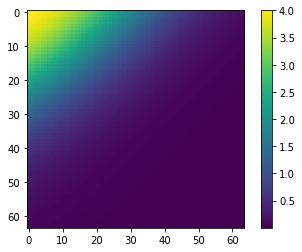

In [34]:
plt.imshow(A[:, :, 0, 0])
_ = plt.colorbar()

In [35]:
nsthosvdTruncatedSvdList = []
nsthosvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=15, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=15, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=9, l=26, distr='rademacher'))
# nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=7, l=16, distr='rademacher'))

nttsvdTruncatedSvdList = []
nttsvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=15, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=15, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=9, l=40, distr='rademacher'))
# nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=8, l=40, distr='rademacher'))


nlrtTruncatedSvdList = []
nlrtTruncatedSvdList.append(TruncatedSvd('SVDr'))

r = 6
tuckerRank = (r, r, r, r)
ttRank = (r, r, r)
itersNum = 100

ex = Experiment(tensor=A,
                tuckerRank=tuckerRank,
                ttRank=ttRank,
                nsthosvdTruncatedSvdList=nsthosvdTruncatedSvdList,
                nttsvdTruncatedSvdList=nttsvdTruncatedSvdList,
                nlrtTruncatedSvdList=nlrtTruncatedSvdList)

In [36]:
ex.runInitialSvd()

TTSVD
-------------------------------------------
time (s.)                    |      5.89882
negative elements (fro)      |  0.038271320
negative elements (che)      |  0.000066502
negative elements (%)        |  49.97767210
relative error (fro)         | 0.0003114214
relative error (che)         | 0.0019745169
SNR (dB)                     | 35.066516034
r2_score                     | 0.9999999005
compression                  |      3120.76
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      2.85288
negative elements (fro)      |  0.003092706
negative elements (che)      |  0.000009039
negative elements (%)        |  32.04879761
relative error (fro)         | 0.0000235993
relative error (che)         | 0.0001598085
SNR (dB)                     | 46.271007316
r2_score                     | 0.9999999994
compression                  |      5924.16
-------------------------------------------


In [56]:
ex.time(itersNum, nttsvd=True, nsthosvd=False, nlrt=False)

NTTSVD
------------------------------------
SVD$_r$                 | 416.28 s.
HMT(1,15), Rad          | 101.45 s.
HMT(0,15), Rad          |  76.93 s.
Tropp(9,40), Rad        |  66.73 s.
------------------------------------


In [57]:
ex.time(itersNum, nttsvd=False, nsthosvd=True, nlrt=False)

NSTHOSVD
------------------------------------
SVD$_r$                 | 347.32 s.
HMT(1,15), Rad          | 145.59 s.
HMT(0,15), Rad          | 103.56 s.
Tropp(9,26), Rad        |  72.32 s.
------------------------------------


In [64]:
ex.time(itersNum, nttsvd=False, nsthosvd=False, nlrt=True)

NLRT
------------------------------------
SVD$_r$                 | 1452.35 s.
------------------------------------


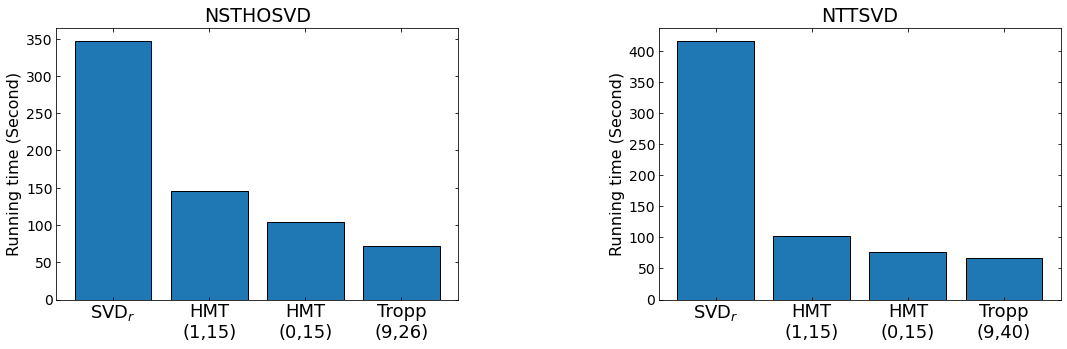

In [163]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=19,
                          ylabelsize=16,
                          xticksize=18,
                          yticksize=14,
                          wspace=0.5,
                          paramsNewLine=True)

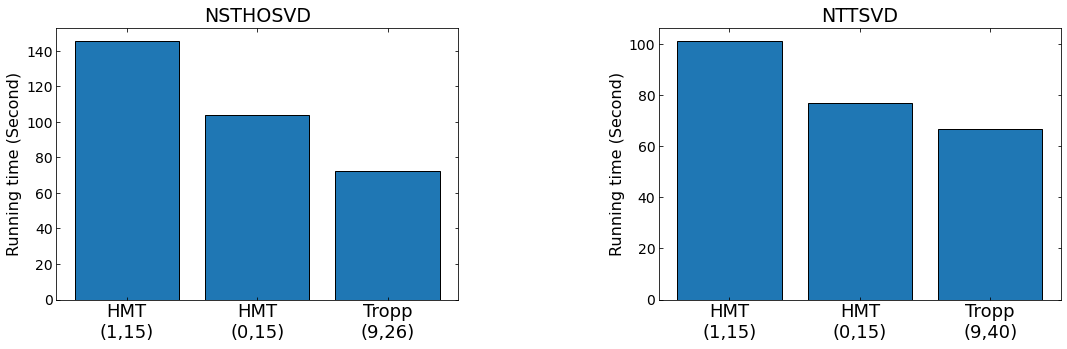

In [162]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=19,
                          ylabelsize=16,
                          xticksize=18,
                          yticksize=14,
                          wspace=0.5,
                          paramsNewLine=True,
                          exclude=[0])

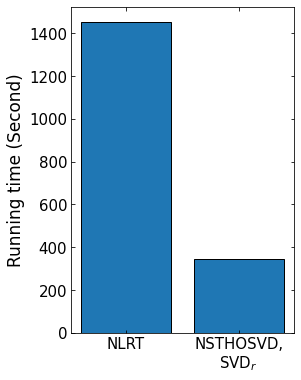

In [182]:
fig, ax = ex.plotRuntimes2(figsize=(4, 6),
                 xticksize=15,
                 yticksize=15,
                 ylabelsize=17,
                 nttsvd=False)

In [58]:
ex.run(itersNum)

NTTSVD
------------------------------------
SVD$_r$                  | 437.65 s.
HMT(1,15), Rad           | 163.68 s.
HMT(0,15), Rad           | 134.31 s.
Tropp(9,40), Rad         | 102.21 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  | 340.07 s.
HMT(1,15), Rad           | 135.49 s.
HMT(0,15), Rad           | 110.41 s.
Tropp(9,26), Rad         | 144.72 s.
------------------------------------
NLRT
------------------------------------
SVD$_r$                  | 2252.57 s.
------------------------------------


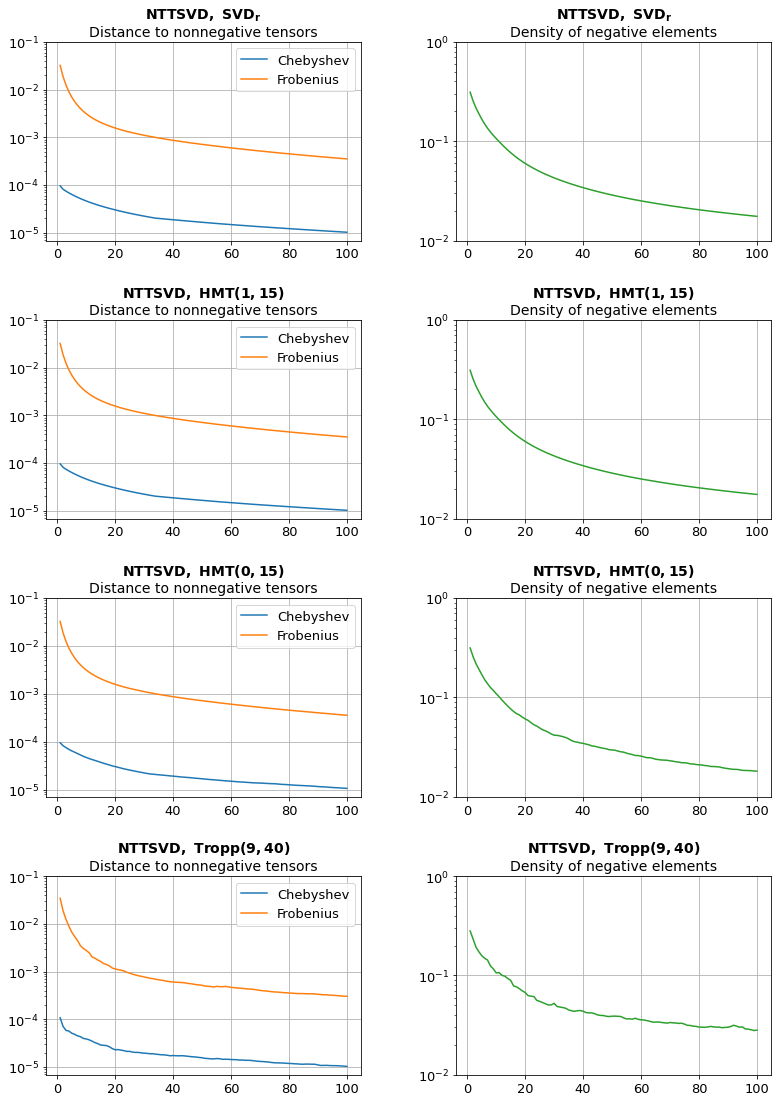

In [159]:
fig, ax = ex.plotConvergence2(nsthosvd=False,
                              figsize=(13, 19),
                              yticks=[10**(-x) for x in range(1, 6)],
                              yticks2=[10**(-x) for x in range(0, 3)],
                              hspace=0.4, wspace=0.3,
                              titlesize=14,
                              ticksize=13,
                              legendsize=13,
                              legendloc='upper right')

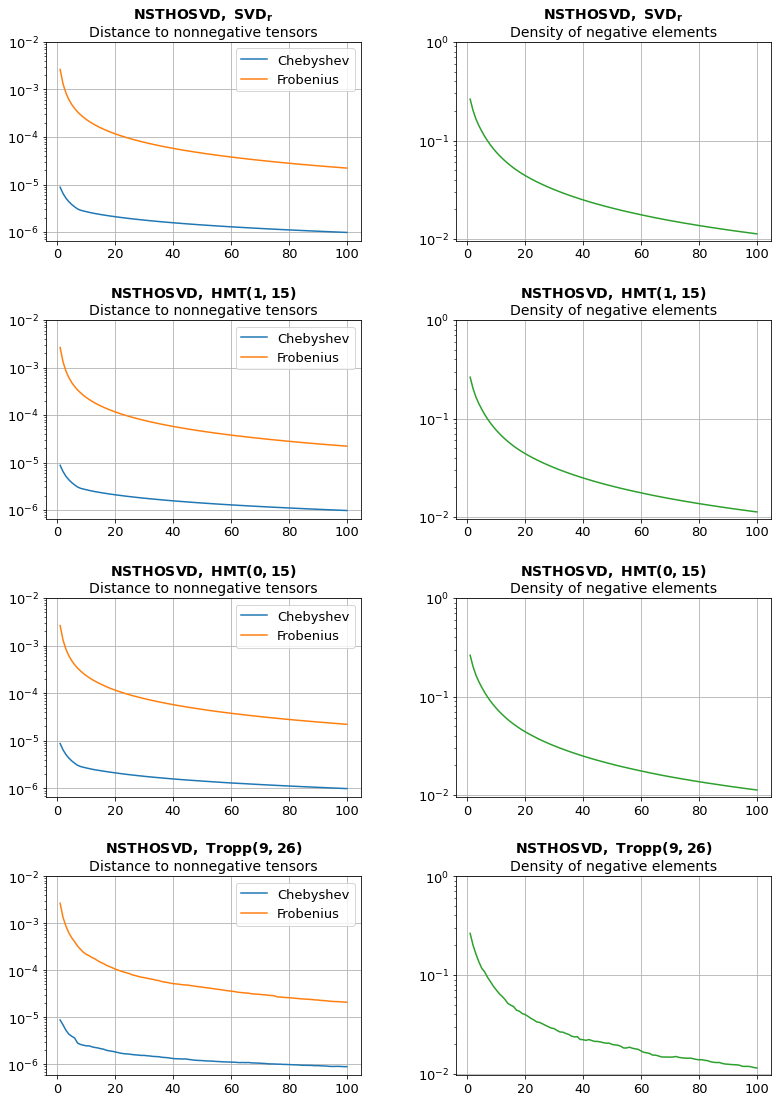

In [161]:
fig, ax = ex.plotConvergence2(nttsvd=False,
                              figsize=(13, 19),
                              yticks=[10**(-x) for x in range(2, 7)],
                              yticks2=[10**(-x) for x in range(0, 3)],
                              hspace=0.4, wspace=0.3,
                              titlesize=14,
                              ticksize=13,
                              legendsize=13,
                              legendloc='upper right')

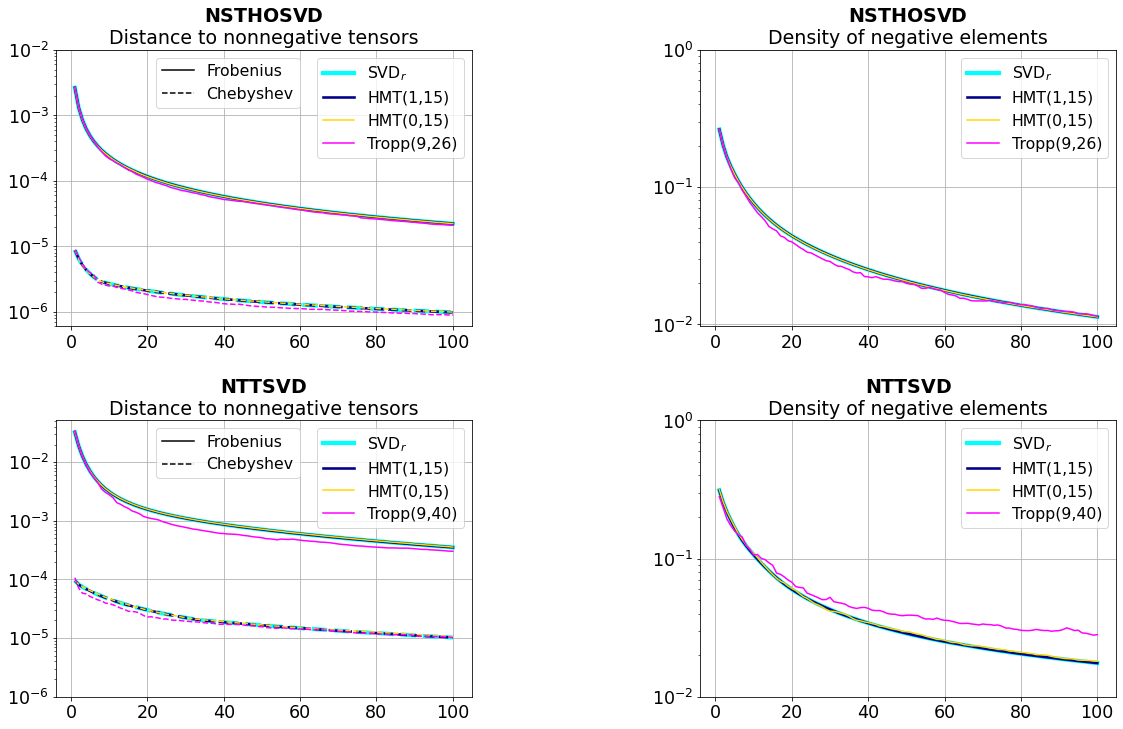

In [211]:
fig, ax = ex.plotConvergence3(figsize=(19, 11.9),
                              yticks=[10**(-x) for x in range(2, 7)],
                              yticks2=[10**(-x) for x in range(0, 3)],
                              wspace=0.55,
                              hspace=0.34,
                              titlesize=19,
                              ticksize=17.5,
                              legendsize=15.74,
                              colors=['aqua', 'darkblue', 'gold', 'fuchsia'],
                              linewidthList1=[4.2, 2.6, None, None],
                              linewidthList2=[4.2, 2.6, None, None],
                              legendloc='upper right',
                              legend2loc=(0.24, 0.79))

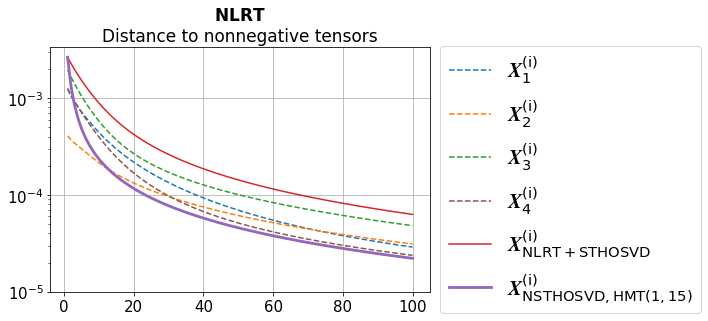

In [93]:
fig, ax = ex.plotConvergence(nttsvd=False,
                             nsthosvd=False,
                             nlrt=True,
                             figsize=(6.8, 4.5),
                             titlesize=17,
                             ticksize=15,
                             legendsize=21,
                             bbox_to_anchor=(1, 1.0485),
                             labelspacing=0.59,
                             colors=['C0', 'C1', 'C2', 'C5', 'C3', 'C4'],
                             yticks=[10**(-x) for x in range(3, 6)])

In [62]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000426848637635769 | 0.001361412080529090 | 33.69726 | 1.000000 |
| HMT(1,15), Rad           | 0.000426848637729479 | 0.001361412254635597 | 33.69726 | 1.000000 |
| HMT(0,15), Rad           | 0.000426975966104347 | 0.001385033913841038 | 33.69597 | 1.000000 |
| Tropp(9,40), Rad         | 0.000509935548121266 | 0.003940485965145624 | 32.92485 | 1.000000 |
------------------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000034352163749390 | 0.000269745288514533 | 44.64046 | 1.000000 |
| HMT(1,15), Rad           | 0

In [63]:
ex.printNegativePart()

| NTTSVD                   | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000353222369734529926 | 0.000010238515367300801 | 1.753723621368408203125 |
| HMT(1,15)                | 0.000353222395884598365 | 0.000010238516049402489 | 1.753723621368408203125 |
| HMT(0,15)                | 0.000356802599117293513 | 0.000010609309413930117 | 1.810824871063232421875 |
| Tropp(9,40)              | 0.000303019667516698024 | 0.000010266680165156017 | 2.817839384078979492188 |
----------------------------------------------------------------------------------------------------------
| NSTHOSVD                 | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000022

## 1.2. 4D, fixed

In [176]:
cov_mat1 = np.array([[0.403, 0.236,  0.159,  0.188],
 [0.236,  0.422, 0.193, 0.313],
 [0.159, 0.193, 0.124, 0.164],
 [0.188, 0.313, 0.164, 0.288]])

cov_mat2 = np.array([[0.400, 0.242 , 0.216, 0.229],
       [0.242 , 0.248, 0.201, 0.231],
       [0.216, 0.201, 0.273, 0.249],
       [0.229, 0.231, 0.249, 0.270]])

mu1 = np.array([0, 0, 0, 0])
mu2 = np.array([0.5, -0.5, 0.5, -0.5])

In [178]:
# np.random.seed(42)

t0 = time()

N = 64
A = np.zeros((N, N, N, N))
grid = np.linspace(start=-1, stop=1, num=N)

# cov_mat1 = np.random.uniform(0, 1, [4,4])
# cov_mat1 = cov_mat1 @ cov_mat1.T
# cov_mat1 = cov_mat1 / np.linalg.norm(cov_mat1)
cov_mat1_inv = np.linalg.inv(cov_mat1)

# cov_mat2 = np.random.uniform(0, 1, [4,4])
# cov_mat2 = cov_mat2 @ cov_mat2.T
# cov_mat2 = cov_mat2 / np.linalg.norm(cov_mat2)
cov_mat2_inv = np.linalg.inv(cov_mat2)

x1, x2, x3, x4 = np.meshgrid(grid, grid, grid, grid)
points = np.concatenate([x[:,:,:,:,np.newaxis] for x in [x1, x2, x3, x4]], axis=4)

points1 = points - mu1
points2 = points - mu2

A += np.exp((-points1 @ cov_mat1_inv * points1).sum(axis=4))
A += np.exp((-points2 @ cov_mat2_inv * points2).sum(axis=4))

print('%d s.' % (time() - t0))

6 s.


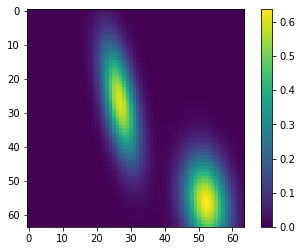

In [172]:
plt.imshow(A[25,:,:, 22])
_ = plt.colorbar()

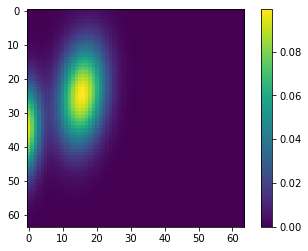

In [173]:
plt.imshow(A[6,:,25, :])
_ = plt.colorbar()

In [179]:
# # np.random.seed(42)

# t0 = time()

# B = np.zeros(shape=(N, N, N, N))

# for i in range(N):
#     for j in range(N):
#         for k in range(N):
#             for l in range(N):
#                 point = np.array([grid[i], grid[j], grid[k], grid[l]])
#                 p1 = point - mu1
#                 p2 = point - mu2
#                 B[i,j,k,l] = np.exp(-p1 @ cov_mat1_inv @ p1) +\
#                              np.exp(-p2 @ cov_mat2_inv @ p2)
# #                              np.exp(-p3 @ cov_mat3_inv @ p3)
            
# print('%d s.' % (time() - t0))

In [174]:
nsthosvdTruncatedSvdList = []
nsthosvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=15, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=15, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=15, l=50, distr='rademacher'))
# nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=7, l=16, distr='rademacher'))

nttsvdTruncatedSvdList = []
nttsvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=19, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=19, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=19, l=40, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=19, l=40, distr='rademacher'))


nlrtTruncatedSvdList = []
# nlrtTruncatedSvdList.append(TruncatedSvd('SVDr'))


itersNum = 3

ex = Experiment(tensor=A,
                tuckerRank=tuckerRank,
                ttRank=ttRank,
                nsthosvdTruncatedSvdList=nsthosvdTruncatedSvdList,
                nttsvdTruncatedSvdList=nttsvdTruncatedSvdList,
                nlrtTruncatedSvdList=nlrtTruncatedSvdList)

In [175]:
print('shape:      ', A.shape)
print('TT-rank:    ', ttRank)
print('Tucker rank:', tuckerRank)
print()
ex.runInitialSvd()

shape:       (64, 64, 64, 64)
TT-rank:     (20, 20, 20)
Tucker rank: (14, 14, 14, 14)

TTSVD
-------------------------------------------
time (s.)                    |     18.76801
negative elements (fro)      |  3.832712693
negative elements (che)      |  0.020673707
negative elements (%)        |  40.03301263
relative error (fro)         | 0.0513475071
relative error (che)         | 0.0806786179
SNR (dB)                     | 12.894806361
r2_score                     | 0.9972639699
compression                  |       312.08
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      6.81125
negative elements (fro)      |  1.000131158
negative elements (che)      |  0.007268508
negative elements (%)        |  38.55170012
relative error (fro)         | 0.0118088877
relative error (che)         | 0.0201049678
SNR (dB)                     | 19.277910066
r2_score                     | 0.9998552895
compression        

In [135]:
ex.time(itersNum) # ex.time(itersNum, nttsvd=False, nsthosvd=False, nlrt=False)

NTTSVD
------------------------------------
SVD$_r$                 |  27.77 s.
HMT(1,19), Rad          |   5.22 s.
HMT(0,19), Rad          |   4.43 s.
Tropp(19,40), Rad       |   4.99 s.
Tropp(19,40), Rad       |   4.71 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                 |  10.09 s.
HMT(1,15), Rad          |   3.93 s.
HMT(0,15), Rad          |   3.98 s.
Tropp(15,50), Rad       |   3.55 s.
------------------------------------


In [136]:
ex.run(itersNum)

NTTSVD
------------------------------------
SVD$_r$                  |  29.65 s.
HMT(1,19), Rad           |   6.37 s.
HMT(0,19), Rad           |   5.86 s.
Tropp(19,40), Rad        |   5.31 s.
Tropp(19,40), Rad        |   5.81 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  |  11.45 s.
HMT(1,15), Rad           |   4.76 s.
HMT(0,15), Rad           |   4.84 s.
Tropp(15,50), Rad        |   3.86 s.
------------------------------------


In [137]:
ex.runInitialSvd()

TTSVD
-------------------------------------------
time (s.)                    |     11.68320
negative elements (fro)      |  5.296796823
negative elements (che)      |  0.022978328
negative elements (%)        |  41.03698134
relative error (fro)         | 0.0668248238
relative error (che)         | 0.0842228458
SNR (dB)                     | 11.750621779
r2_score                     | 0.9953527006
compression                  |       344.93
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      3.54626
negative elements (fro)      |  4.689496658
negative elements (che)      |  0.031939054
negative elements (%)        |  39.27159905
relative error (fro)         | 0.0650013845
relative error (che)         | 0.0994970287
SNR (dB)                     | 11.870773930
r2_score                     | 0.9956028607
compression                  |      1892.52
-------------------------------------------


In [138]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.070945286282410314 | 0.094936171571649866 | 11.49076 | 0.994762 |
| HMT(1,19), Rad           | 0.076063420375894211 | 0.081554397193094513 | 11.18824 | 0.993979 |
| HMT(0,19), Rad           | 0.168614852722551306 | 0.151733702938501303 |  7.73104 | 0.970412 |
| Tropp(19,40), Rad        | 0.187830982828406018 | 0.171037294770306075 |  7.26233 | 0.963284 |
| Tropp(19,40), Rad        | 0.226619551435200517 | 0.219556656823165025 |  6.44703 | 0.946553 |
------------------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0

In [139]:
ex.printNegativePart()

| NTTSVD                   | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 1.547201402938054970448 | 0.011123202298397296892 | 26.914101839065551757812 |
| HMT(1,19)                | 1.653092152615981191843 | 0.012105797080922277298 | 24.438071250915527343750 |
| HMT(0,19)                | 5.333313748714714641608 | 0.051496432640483716381 | 23.462074995040893554688 |
| Tropp(19,40)             | 6.201972157125704931957 | 0.039420383534293869376 | 25.774312019348144531250 |
| Tropp(19,40)             | 13.646087617300379335461 | 0.094935933320579410366 | 30.357986688613891601562 |
----------------------------------------------------------------------------------------------------------
| NSTHOSVD                 | negative elements (fro) | negative elements (che) |   negative elements (%) |
-------------------------------

# 2. Function Based Tensors

## 2.1 Hilbert Tensor

An Nth order Hilbert tensor is defined as follows
$$A(i_1, \dots, i_N) = \frac{1}{i_1 + \dots + i_N - N + 1}$$

In [15]:
shape = [128, 128, 128]

a = np.empty(shape=shape)

m, n, l = a.shape
for i in range(m):
    for j in range(n):
        for k in range(l):
            a[i, j, k] = 1 / ((i+1) + (j+1) + (k+1) - 3 + 1)

In [49]:
nsthosvdTruncatedSvdList = []
nsthosvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=11, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=15, distr='rademacher'))
# nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=7, l=14, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=6, l=35, distr='rademacher'))

nttsvdTruncatedSvdList = []
nttsvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=12, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=15, distr='rademacher'))
# nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=7, l=14, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=4, l=30, distr='rademacher'))

nlrtTruncatedSvdList = []
nlrtTruncatedSvdList.append(TruncatedSvd('SVDr'))

tuckerRank = (3, 2, 4)
ttRank = (3, 2)
itersNum = 250

ex = Experiment(tensor=a,
                tuckerRank=tuckerRank,
                ttRank=ttRank,
                nsthosvdTruncatedSvdList=nsthosvdTruncatedSvdList,
                nttsvdTruncatedSvdList=nttsvdTruncatedSvdList,
                nlrtTruncatedSvdList=nlrtTruncatedSvdList)

In [50]:
ex.runInitialSvd()

TTSVD
-------------------------------------------
time (s.)                    |      0.32092
negative elements (fro)      |  0.097678643
negative elements (che)      |  0.016309723
negative elements (%)        |   0.00634193
relative error (fro)         | 0.0771893852
relative error (che)         | 0.3671764120
SNR (dB)                     | 11.124424184
r2_score                     | 0.9798626863
compression                  |      1489.45
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      0.29869
negative elements (fro)      |  0.097543042
negative elements (che)      |  0.016291074
negative elements (%)        |   0.00634193
relative error (fro)         | 0.0771894871
relative error (che)         | 0.3671781751
SNR (dB)                     | 11.124418451
r2_score                     | 0.9798626331
compression                  |      1783.29
-------------------------------------------


In [48]:
ex.time(itersNum, nttsvd=False, nsthosvd=True, nlrt=False)

NSTHOSVD
------------------------------------
SVD$_r$                 | 118.55 s.
HMT(1,11), Rad          |  16.83 s.
HMT(0,15), Rad          |  14.32 s.
Tropp(6,35), Rad        |  10.67 s.
------------------------------------


In [49]:
ex.time(itersNum, nttsvd=True, nsthosvd=False, nlrt=False)

NTTSVD
------------------------------------
SVD$_r$                 | 121.79 s.
HMT(1,12), Rad          |  16.35 s.
HMT(0,15), Rad          |  13.32 s.
Tropp(4,30), Rad        |   9.90 s.
------------------------------------


In [50]:
ex.time(itersNum, nttsvd=False, nsthosvd=False, nlrt=True)

NLRT
------------------------------------
SVD$_r$                 | 390.04 s.
------------------------------------


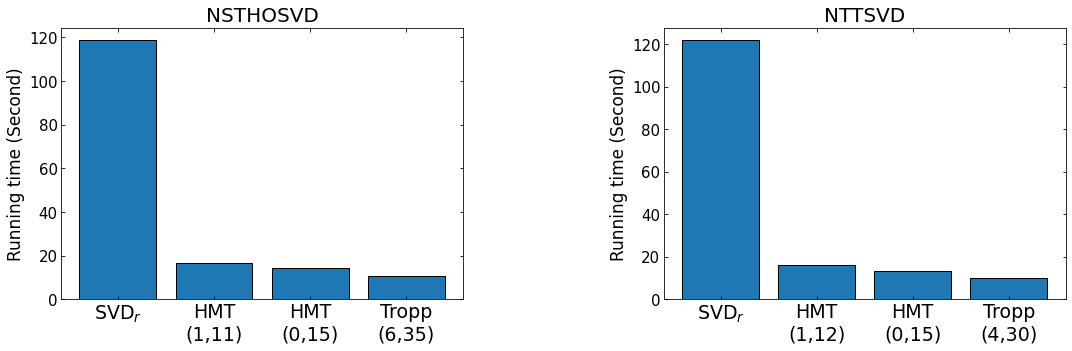

In [51]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=20,
                          ylabelsize=17,
                          xticksize=19,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True)

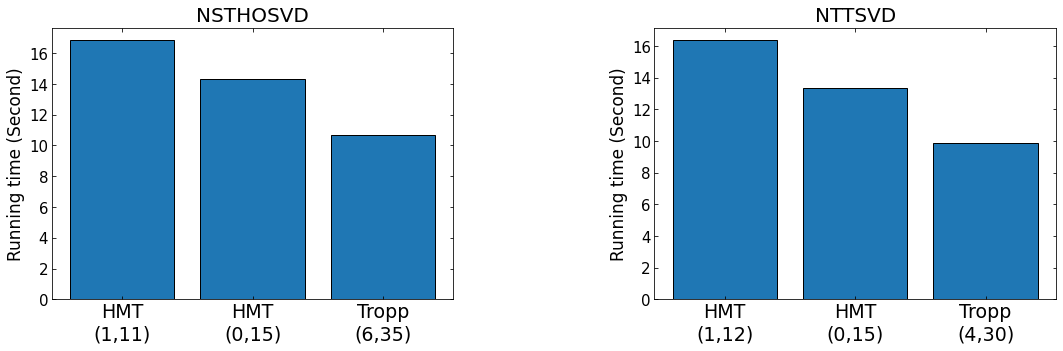

In [52]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=20,
                          ylabelsize=17,
                          xticksize=19,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True,
                          exclude=[0])

In [79]:
ex.run(itersNum)

NTTSVD
------------------------------------
SVD$_r$                  | 125.60 s.
HMT(1,12), Rad           |  25.94 s.
HMT(0,15), Rad           |  22.04 s.
Tropp(4,30), Rad         |  19.32 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  | 130.10 s.
HMT(1,11), Rad           |  25.85 s.
HMT(0,15), Rad           |  24.48 s.
Tropp(6,35), Rad         |  22.81 s.
------------------------------------
NLRT
------------------------------------
SVD$_r$                  | 497.19 s.
------------------------------------


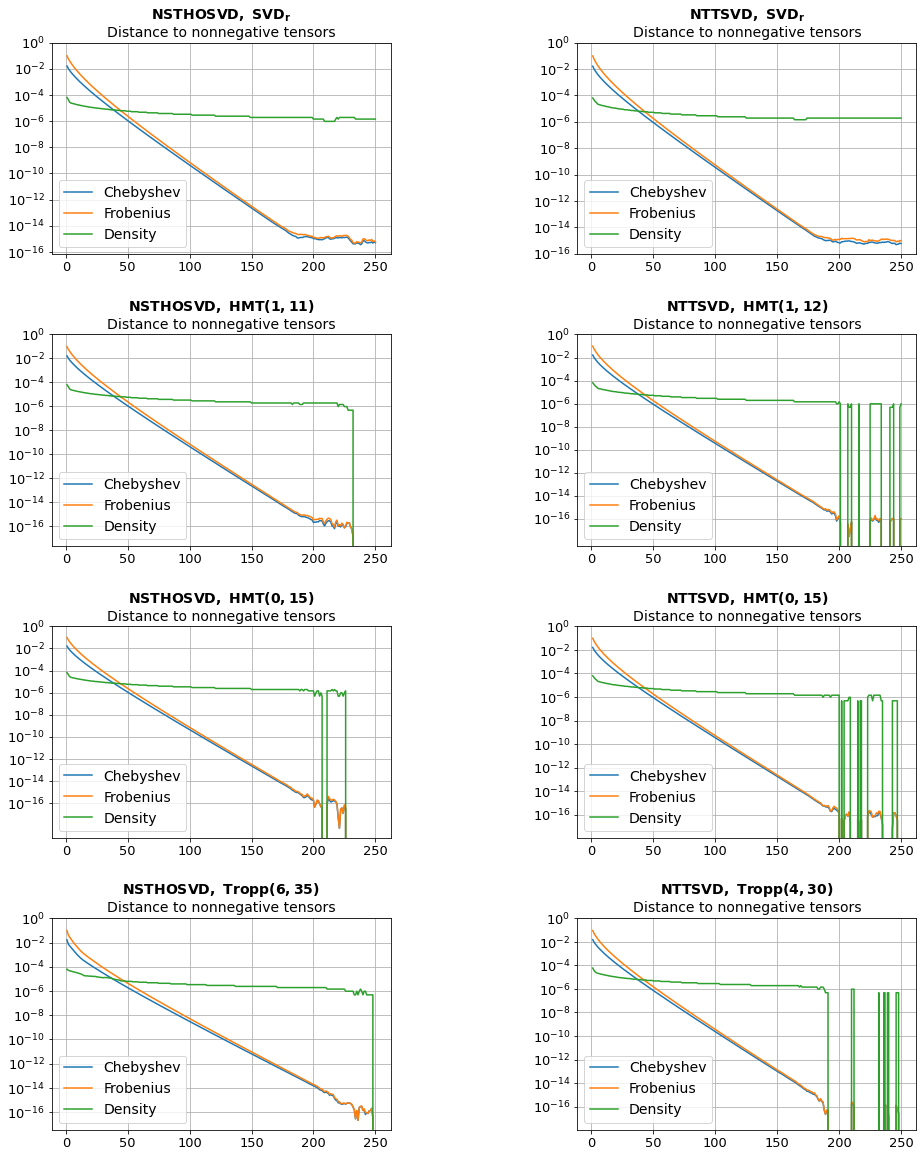

In [54]:
fig, ax = ex.plotConvergence(nlrt=False,
                             figsize=(15.5, 20),
                             yticks=[10**(-x) for x in range(0, 17, 2)],
                             hspace=0.38, wspace=0.55,
                             titlesize=14,
                             ticksize=13,
                             legendsize=14,
                             legendloc='lower left')

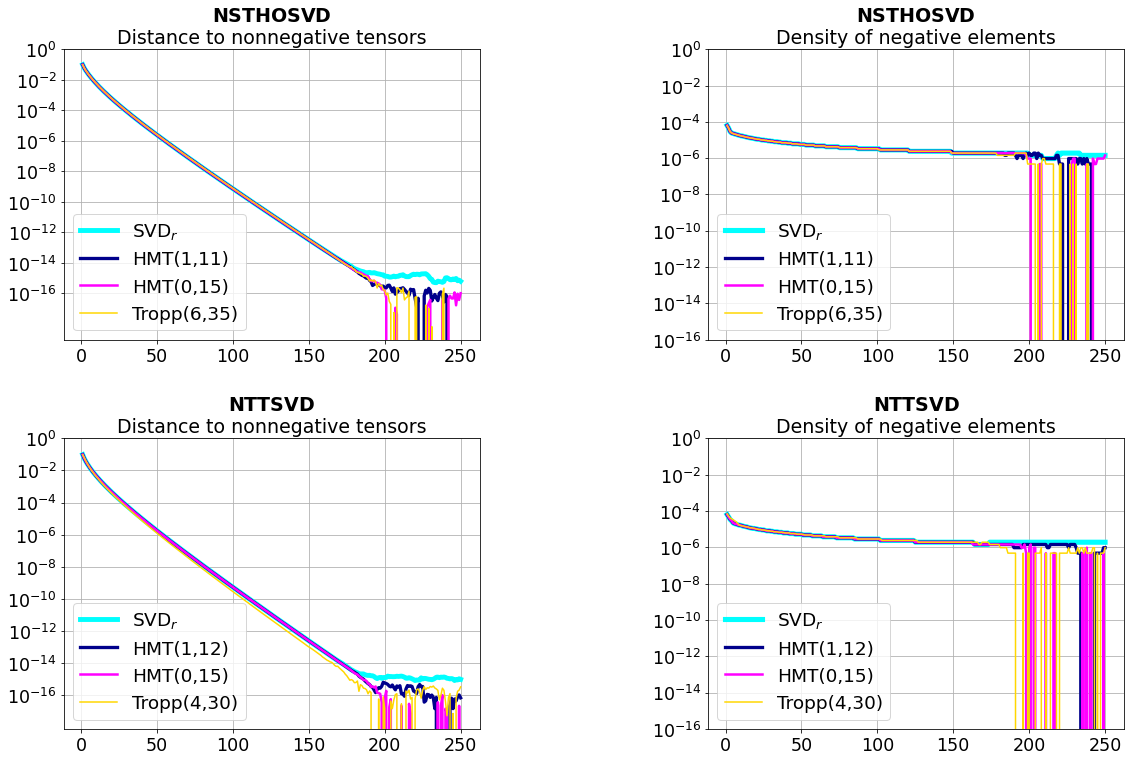

In [54]:
# fig, ax = ex.plotConvergence3(figsize=(19, 12.5),
#                               yticks=[10**(-x) for x in range(0, 17, 2)],
#                               yticks2=[10**(-x) for x in range(0, 17, 2)],
#                               wspace=0.55,
#                               hspace=0.34,
#                               titlesize=19,
#                               ticksize=17.5,
#                               legendsize=18.5,
#                               colors=['aqua', 'darkblue', 'fuchsia', 'gold'],
#                               linewidthList1=[4.9, 3.3, 2.5, 1.5],
#                               linewidthList2=[5.1, 3.3, 2.5, 1.5],
#                               legendloc='lower left',
#                               legend2loc='upper right',)

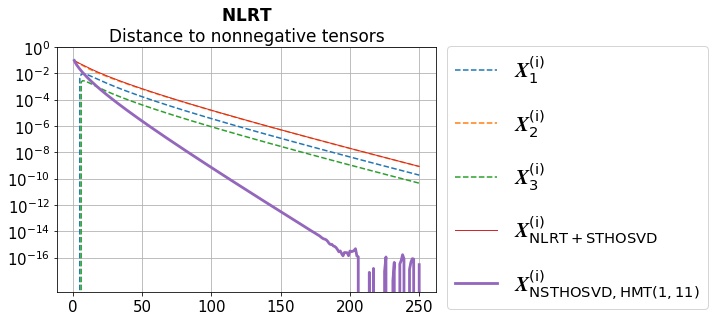

In [90]:
fig, ax = ex.plotConvergence(nttsvd=False,
                             nsthosvd=False,
                             nlrt=True,
                             figsize=(6.8, 4.5),
                             titlesize=17,
                             ticksize=15,
                             legendsize=21,
                             bbox_to_anchor=(1, 1.0485),
                             labelspacing=1.06,
                             linewidthList=[None, None, None, 1.0, 2.8],
                             yticks=[10**(-x) for x in range(0, 17, 2)])

In [108]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.078820710858905962 | 0.394445165838060552 | 11.03360 | 0.979003 |
| HMT(1,12), Rad           | 0.078820710858909931 | 0.394445165838113398 | 11.03360 | 0.979003 |
| HMT(0,15), Rad           | 0.078820710858910514 | 0.394445165838174572 | 11.03360 | 0.979003 |
| Tropp(4,30), Rad         | 0.081350684512848909 | 0.382272172954121414 | 10.89639 | 0.977633 |
------------------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.078947343689500044 | 0.395001547796862029 | 11.02662 | 0.978935 |
| HMT(1,11), Rad           | 0

In [109]:
ex.printNegativePart()

| NTTSVD                   | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000000000000000935290 | 0.000000000000000582867 | 0.000190734863281250000 |
| HMT(1,12)                | 0.000000000000000000000 | 0.000000000000000000000 | 0.000000000000000000000 |
| HMT(0,15)                | 0.000000000000000126333 | 0.000000000000000119276 | 0.000095367431640625000 |
| Tropp(4,30)              | 0.000000000000000000000 | 0.000000000000000000000 | 0.000000000000000000000 |
----------------------------------------------------------------------------------------------------------
| NSTHOSVD                 | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000000

## 3. Hyperspectral Images (HSIs)

### 3.1. Washington, DC
https://github.com/JakobSig/HSI2RGB/blob/master/washington_hsi.mat

shape: (191, 307, 307)
min_elem: 0.0
max_elem: 1.0


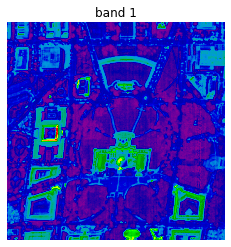

In [100]:
HSI_path = 'data/washington_hsi.mat'
HSI_mat = spio.loadmat(HSI_path)
HSI_data = HSI_mat['Y']
HSI_data = np.moveaxis(HSI_data, -1, 0)
img = HSI_data / HSI_data.max()

print('shape: %s\nmin_elem: %.1f\nmax_elem: %.1f' % (img.shape, img.min(), img.max()))
band = 1
plt.imshow(img[band], cmap='nipy_spectral')
plt.title(f'band {band}')
plt.axis('off')
plt.show()

In [101]:
nsthosvdTruncatedSvdList = []
nsthosvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=1,  k=75, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=0,  k=75, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=60, l=150, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=50, l=150, distr='rademacher'))


nttsvdTruncatedSvdList = []
nttsvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=75, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=75, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=60, l=150, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=50, l=150, distr='rademacher'))

nlrtTruncatedSvdList = []
nlrtTruncatedSvdList.append(TruncatedSvd('SVDr'))


tuckerRank = [33, 40, 40]
ttRank = [33, 33]
itersNum = 100

ex = Experiment(tensor=img,
                tuckerRank=tuckerRank,
                ttRank=ttRank,
                nsthosvdTruncatedSvdList=nsthosvdTruncatedSvdList,
                nttsvdTruncatedSvdList=nttsvdTruncatedSvdList,
                nlrtTruncatedSvdList=nlrtTruncatedSvdList)

In [102]:
ex.runInitialSvd()

TTSVD
-------------------------------------------
time (s.)                    |      5.55385
negative elements (fro)      |  2.218144504
negative elements (che)      |  0.068239673
negative elements (%)        |   3.14982163
relative error (fro)         | 0.1814581084
relative error (che)         | 0.4532713527
SNR (dB)                     |  7.412236206
r2_score                     | 0.9419990389
compression                  |        51.32
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      3.56277
negative elements (fro)      |  2.081440565
negative elements (che)      |  0.070907043
negative elements (%)        |   2.89294388
relative error (fro)         | 0.1845035115
relative error (che)         | 0.4622325103
SNR (dB)                     |  7.339953638
r2_score                     | 0.9400358470
compression                  |       215.17
-------------------------------------------


In [110]:
ex.time(itersNum)

NTTSVD
------------------------------------
SVD$_r$                 | 341.25 s.
HMT(1,75), Rad          | 236.89 s.
HMT(0,75), Rad          | 173.53 s.
Tropp(60,150), Rad      | 151.50 s.
Tropp(50,150), Rad      | 102.17 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                 | 440.02 s.
HMT(1,75), Rad          | 296.75 s.
HMT(0,75), Rad          | 268.61 s.
Tropp(60,150), Rad      | 225.04 s.
Tropp(50,150), Rad      | 131.63 s.
------------------------------------
NLRT
------------------------------------
SVD$_r$                 | 1874.12 s.
------------------------------------


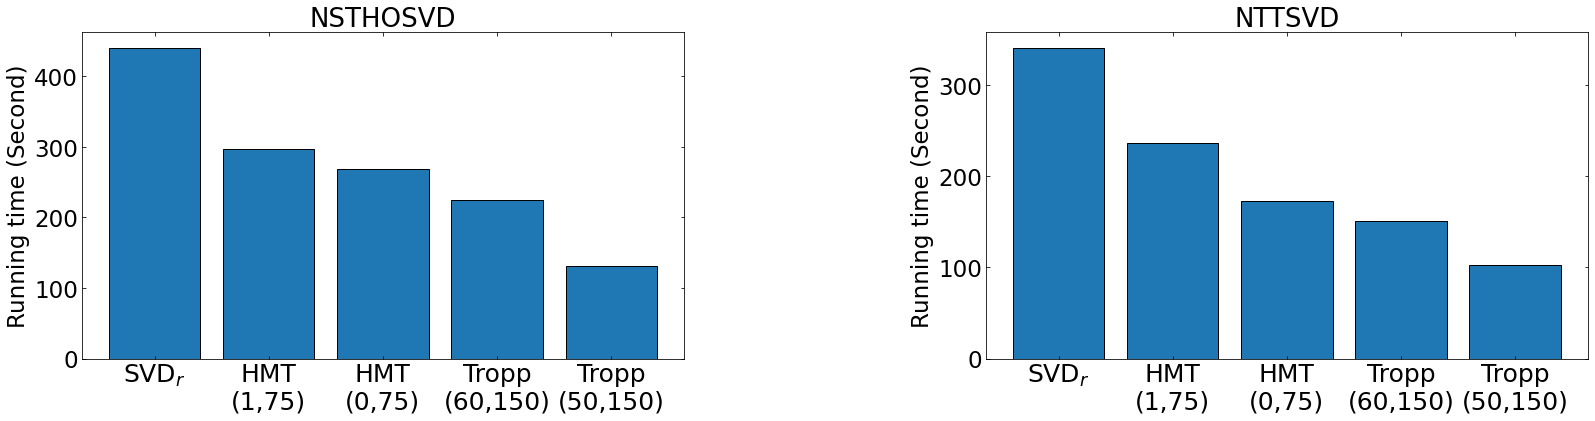

In [196]:
fig, ax = ex.plotRuntimes(figsize=(27, 6),
                          titlesize=26,
                          ylabelsize=23,
                          xticksize=25,
                          yticksize=23,
                          wspace=0.5,
                          paramsNewLine=True)

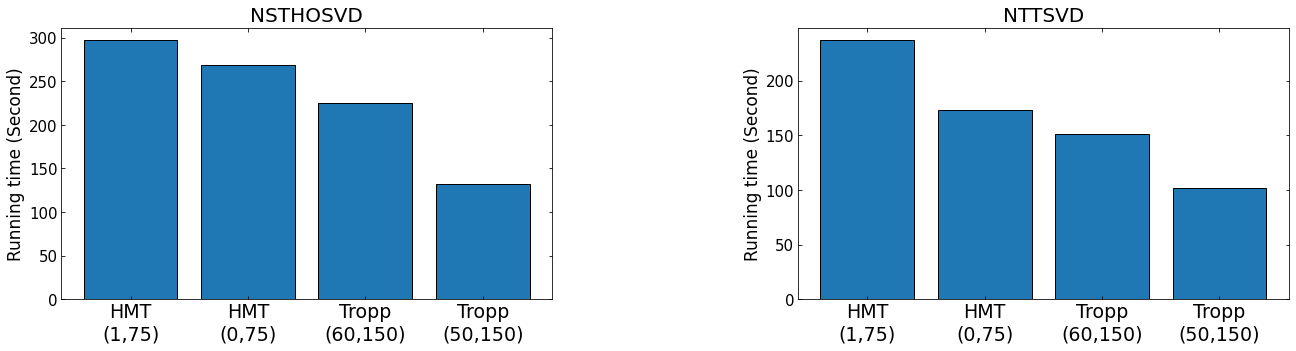

In [180]:
fig, ax = ex.plotRuntimes(figsize=(22, 5),
                          titlesize=20,
                          ylabelsize=17,
                          xticksize=19,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True,
                          exclude=[0])

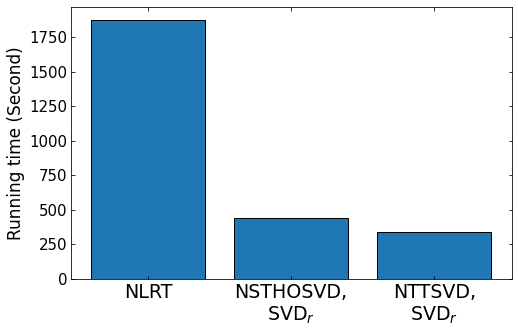

In [171]:
fig, ax = ex.plotRuntimes2(figsize=(7.9, 5),
                          ylabelsize=17,
                          xticksize=19,
                          yticksize=15,
                          paramsNewLine=True,
                          exclude=[0])

In [103]:
ex.run(itersNum)

NTTSVD
------------------------------------
SVD$_r$                  | 309.73 s.
HMT(1,75), Rad           | 244.33 s.
HMT(0,75), Rad           | 176.20 s.
Tropp(60,150), Rad       | 112.98 s.
Tropp(50,150), Rad       | 104.21 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  | 383.41 s.
HMT(1,75), Rad           | 232.15 s.
HMT(0,75), Rad           | 182.98 s.
Tropp(60,150), Rad       | 117.75 s.
Tropp(50,150), Rad       |  97.70 s.
------------------------------------
NLRT
------------------------------------
SVD$_r$                  | 1288.02 s.
------------------------------------


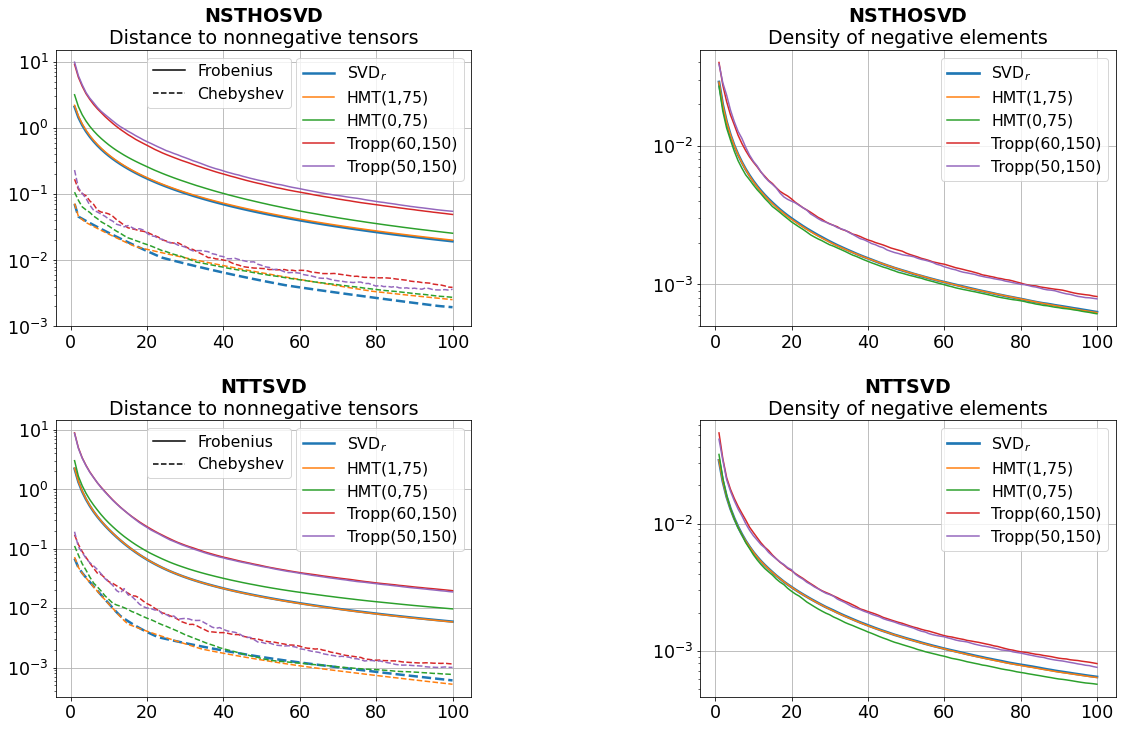

In [31]:
fig, ax = ex.plotConvergence3(figsize=(19, 11.9),
                              yticks=[10**(-x) for x in range(-1, 4)],
                              wspace=0.55,
                              hspace=0.34,
                              titlesize=19,
                              ticksize=17.5,
                              legendsize=15.74,
                              linewidthList1=[2.5, None, None, None, None],
                              linewidthList2=[2.7, None, None, None, None],
                              legendloc='upper right',
                              legend2loc=(0.22, 0.79))

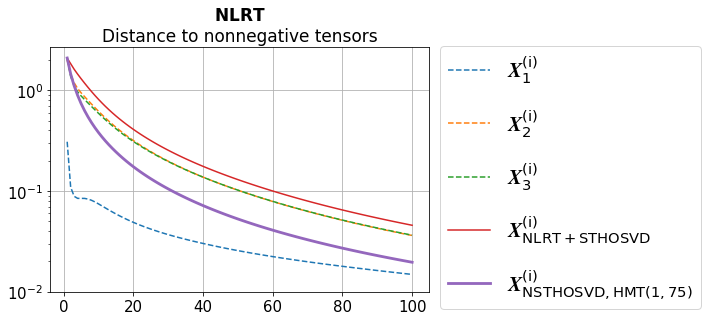

In [104]:
fig, ax = ex.plotConvergence(nttsvd=False,
                             nsthosvd=False,
                             nlrt=True,
                             figsize=(6.8, 4.5),
                             titlesize=17,
                             ticksize=15,
                             legendsize=21,
                             bbox_to_anchor=(1, 1.0485),
                             labelspacing=1.06,
                             yticks=[10**(-x) for x in range(0, 3)])

In [294]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.181579502297610607 | 0.453385570169014596 |  7.40933 | 0.941921 |
| HMT(1,75), Rad           | 0.181920945062768208 | 0.451233362252156656 |  7.40117 | 0.941703 |
| HMT(0,75), Rad           | 0.205804808424166180 | 0.421808064484993528 |  6.86544 | 0.925391 |
| Tropp(60,150), Rad       | 0.260075636467416105 | 0.490671667316297855 |  5.84900 | 0.880853 |
| Tropp(50,150), Rad       | 0.265719655611455496 | 0.469976455653170089 |  5.75576 | 0.875626 |
------------------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0

In [295]:
ex.printNegativePart()

| NTTSVD                   | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.005922567015812484244 | 0.000607109577990490312 | 0.062494587274357742135 |
| HMT(1,75)                | 0.005958306694072599760 | 0.000653387737757387473 | 0.061478008654694854540 |
| HMT(0,75)                | 0.009961748832986932339 | 0.000950170741172207556 | 0.054795254122156862586 |
| Tropp(60,150)            | 0.017927882091085312055 | 0.001066244403684183132 | 0.073632511495254376888 |
| Tropp(50,150)            | 0.018782935052666104719 | 0.001529099978506182674 | 0.080842998098109158933 |
----------------------------------------------------------------------------------------------------------
| NSTHOSVD                 | negative elements (fro) | negative elements (che) |   negative elements (%) |
-------------------------------------

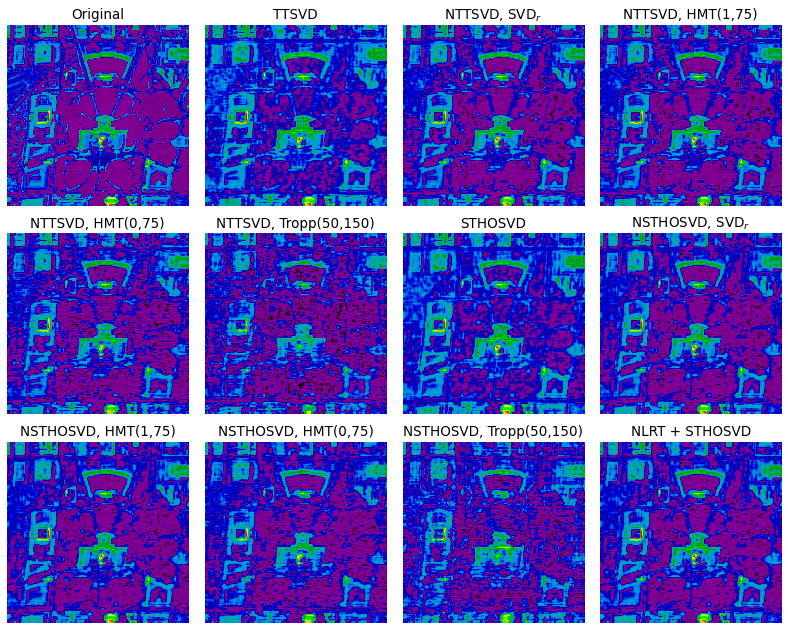

In [157]:
fig, ax = ex.showApproximations(band=50,
                                figsize=(14, 11),
                                ncols=4,
                                wspace=0.05,
                                hspace=0.15,
                                titlesize=13.5,
                                cmap='nipy_spectral',
                                exclude=[5, 11])

### 1.2. WHU-Hi-LongKou
http://rsidea.whu.edu.cn/resource_WHUHi_sharing.htm

shape: (270, 550, 400)
min_elem: 0.0
max_elem: 28.1


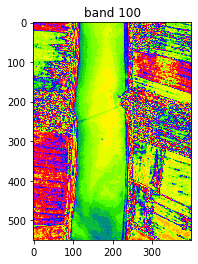

In [4]:
# original image

HSI_path = 'data/WHU_Hi_LongKou.mat'
HSI_mat = spio.loadmat(HSI_path)
HSI_data = HSI_mat['WHU_Hi_LongKou']
HSI_data = np.moveaxis(HSI_data, -1, 0)

img = HSI_data

print('shape: %s\nmin_elem: %.1f\nmax_elem: %.1f' % (img.shape, img.min(), img.max()))
band = 100
plt.imshow(img[band], cmap='prism')
plt.title(f'band {band}')
plt.show()

shape: (270, 200, 200)
min_elem: 0.0
max_elem: 1.0


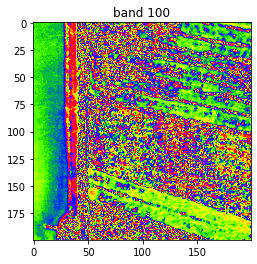

In [12]:
# subimage

HSI_path = 'data/WHU_Hi_LongKou.mat'
HSI_mat = spio.loadmat(HSI_path)
HSI_data = HSI_mat['WHU_Hi_LongKou']
HSI_data = np.moveaxis(HSI_data, -1, 0)

img = HSI_data[:, 0:0+200, 200:200+200]
img /= img.max() #

print('shape: %s\nmin_elem: %.1f\nmax_elem: %.1f' % (img.shape, img.min(), img.max()))
band = 100
plt.imshow(img[band], cmap='prism')
plt.title(f'band {band}')
plt.show()

In [13]:
nsthosvdTruncatedSvdList = []
nsthosvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=34, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=34, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=19, l=42, distr='rademacher'))


nttsvdTruncatedSvdList = []
nttsvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=34, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=34, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=19, l=42, distr='rademacher'))

nlrtTruncatedSvdList = []
nlrtTruncatedSvdList.append(TruncatedSvd('SVDr'))


tuckerRank = [17, 16, 17]
ttRank = [15, 15]
itersNum = 100

ex = Experiment(tensor=img,
                tuckerRank=tuckerRank,
                ttRank=ttRank,
                nsthosvdTruncatedSvdList=nsthosvdTruncatedSvdList,
                nttsvdTruncatedSvdList=nttsvdTruncatedSvdList,
                nlrtTruncatedSvdList=nlrtTruncatedSvdList)

In [14]:
ex.runInitialSvd()

TTSVD
-------------------------------------------
time (s.)                    |      1.11122
negative elements (fro)      |  0.204293489
negative elements (che)      |  0.032476701
negative elements (%)        |   0.00439815
relative error (fro)         | 0.0824982598
relative error (che)         | 0.2826899290
SNR (dB)                     | 10.835552120
r2_score                     | 0.9843181597
compression                  |       207.49
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      0.89595
negative elements (fro)      |  0.030169602
negative elements (che)      |  0.006397204
negative elements (%)        |   0.00128704
relative error (fro)         | 0.0829690844
relative error (che)         | 0.2638227046
SNR (dB)                     | 10.810837026
r2_score                     | 0.9841386374
compression                  |       682.94
-------------------------------------------


In [27]:
ex.time(itersNum, nsthosvd=True, nttsvd=False, nlrt=False)

NSTHOSVD
------------------------------------
SVD$_r$                 |  77.87 s.
HMT(1,34), Rad          |  30.64 s.
HMT(0,34), Rad          |  21.78 s.
Tropp(19,42), Rad       |  17.82 s.
------------------------------------


In [28]:
ex.time(itersNum, nsthosvd=False, nttsvd=True, nlrt=False)

NTTSVD
------------------------------------
SVD$_r$                 |  67.37 s.
HMT(1,34), Rad          |  40.93 s.
HMT(0,34), Rad          |  24.73 s.
Tropp(19,42), Rad       |  17.57 s.
------------------------------------


In [29]:
ex.time(itersNum, nsthosvd=False, nttsvd=False, nlrt=True)

NLRT
------------------------------------
SVD$_r$                 | 251.03 s.
------------------------------------


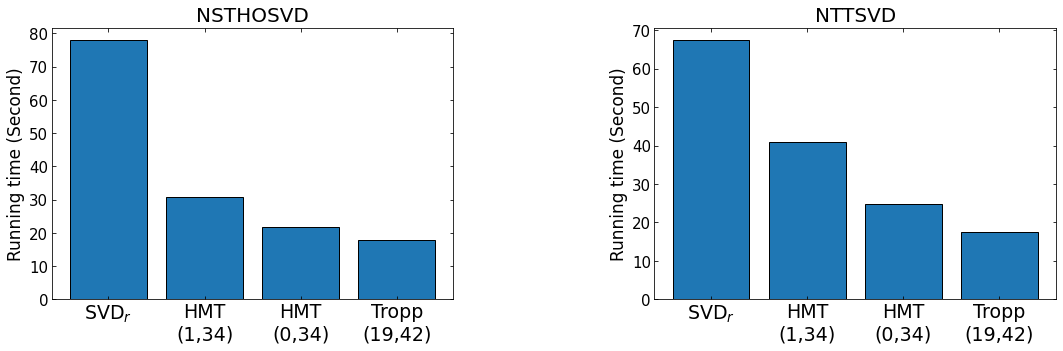

In [34]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=20,
                          ylabelsize=17,
                          xticksize=19,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True)

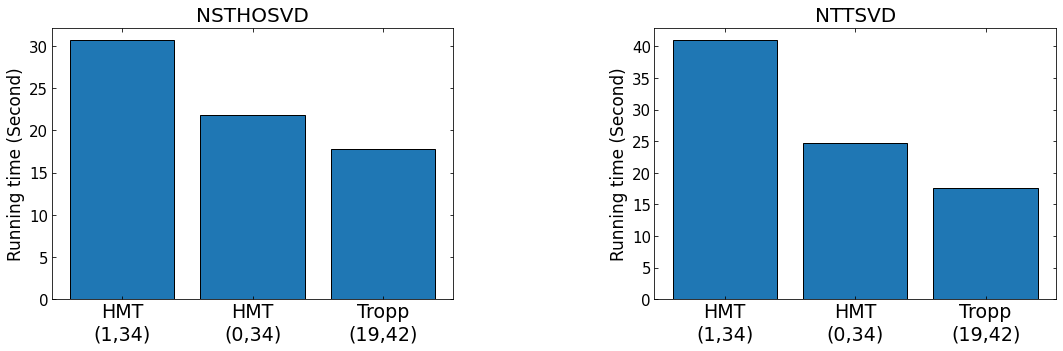

In [35]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=20,
                          ylabelsize=17,
                          xticksize=19,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True,
                          exclude=[0])

In [98]:
ex.run(itersNum)

NTTSVD
------------------------------------
SVD$_r$                  | 108.75 s.
HMT(1,34), Rad           |  45.79 s.
HMT(0,34), Rad           |  36.42 s.
Tropp(19,42), Rad        |  33.20 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  | 107.38 s.
HMT(1,34), Rad           |  47.77 s.
HMT(0,34), Rad           |  35.57 s.
Tropp(19,42), Rad        |  34.15 s.
------------------------------------
NLRT
------------------------------------
SVD$_r$                  | 383.85 s.
------------------------------------


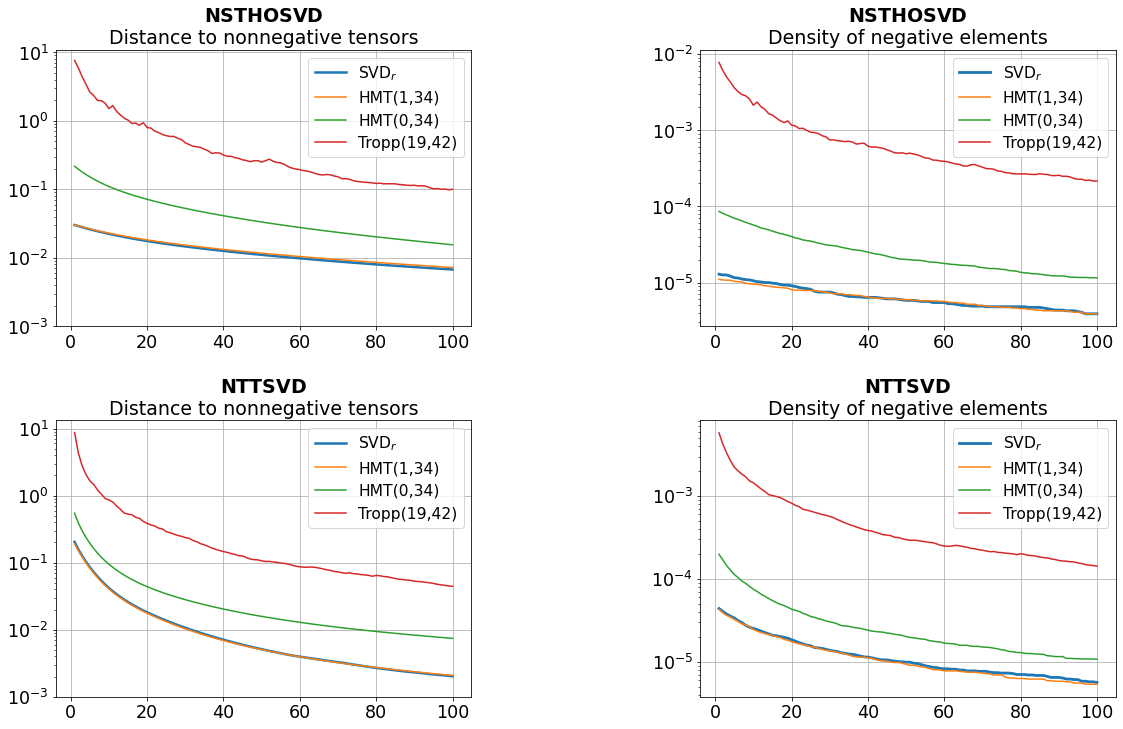

In [67]:
fig, ax = ex.plotConvergence3(figsize=(19, 11.9),
                              yticks=[10**(-x) for x in range(-1, 4)],
                              wspace=0.55,
                              hspace=0.34,
                              titlesize=19,
                              ticksize=17.5,
                              legendsize=15.53,
                              linewidthList1=[2.5, None, None, None, None],
                              linewidthList2=[2.8, None, None, None, None],
                              legendloc='upper right',
                              legend2loc=(0.24, 0.79))

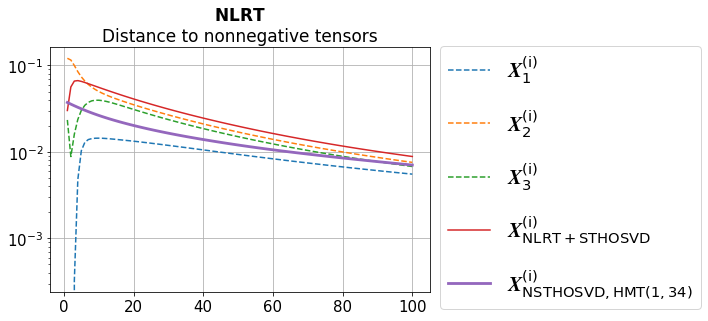

In [99]:
fig, ax = ex.plotConvergence(nttsvd=False,
                             nsthosvd=False,
                             nlrt=True,
                             figsize=(6.8, 4.5),
                             titlesize=17,
                             ticksize=15,
                             legendsize=21,
                             bbox_to_anchor=(1, 1.0485),
                             labelspacing=1.06,
                             yticks=[10**(-x) for x in range(1, 4)])

In [60]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.082500234246253967 | 0.282574713230133057 | 10.83545 | 0.984317 |
| HMT(1,34), Rad           | 0.082577420449512828 | 0.278236079085329435 | 10.83139 | 0.984288 |
| HMT(0,34), Rad           | 0.095237885909574660 | 0.283193563747049737 | 10.21190 | 0.979101 |
| Tropp(19,42), Rad        | 0.160784731292061528 | 0.512816775568728400 |  7.93755 | 0.940435 |
------------------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | SNR (dB) | r2_score |
------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.082973048090934753 | 0.263820350170135498 | 10.81063 | 0.984137 |
| HMT(1,34), Rad           | 0

In [61]:
ex.printNegativePart()

| NTTSVD                   | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.002024613553658127785 | 0.000649843248538672924 | 0.000564814814814814867 |
| HMT(1,34)                | 0.002082676756424014456 | 0.000663021811808324089 | 0.000537037037037037040 |
| HMT(0,34)                | 0.007439192926512796893 | 0.001933984445454755901 | 0.001074074074074074080 |
| Tropp(19,42)             | 0.044479758977427966138 | 0.005290103428610272267 | 0.014231481481481482107 |
----------------------------------------------------------------------------------------------------------
| NSTHOSVD                 | negative elements (fro) | negative elements (che) |   negative elements (%) |
----------------------------------------------------------------------------------------------------------
| SVD$_r$                  | 0.006754

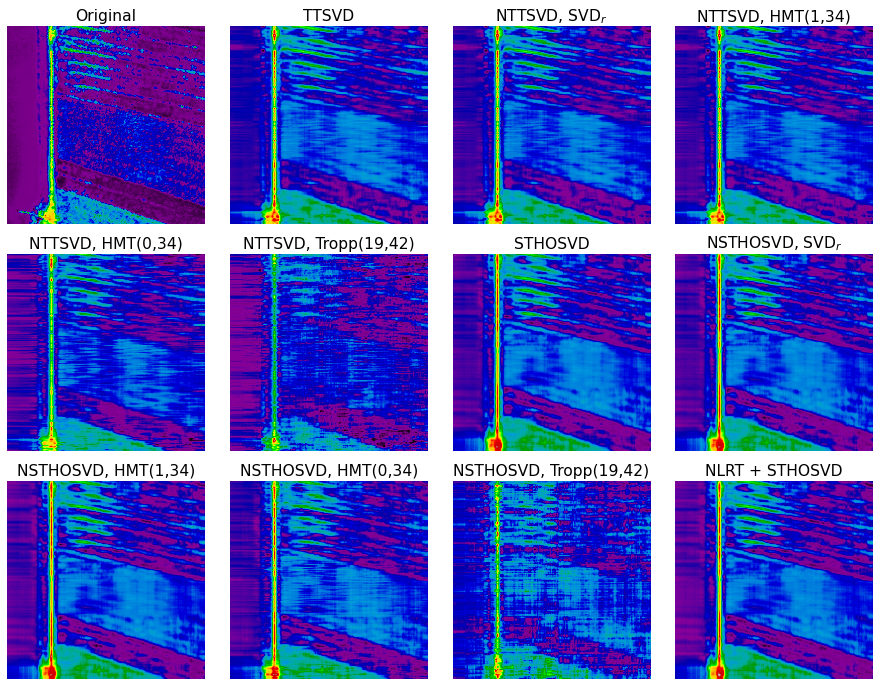

In [255]:
fig, ax = ex.showApproximations(band=100,
                                figsize=(15.6, 12),
                                ncols=4,
                                wspace=0.1,
                                hspace=0.15,
                                titlesize=15.5,
                                cmap='nipy_spectral')